# Getting dependencies
opencv - pyton, labelme, tensorflow, tensorflow - gpu, matplotlib
albumentations

In [20]:
#import tensorflow as tf
#print(tf.__version__)

In [21]:
import sys
print(sys.version)

3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:24:38) 
[Clang 12.0.1 ]


# Collecting images using OpenCV

In [22]:
import os
import time
import uuid
import cv2

In [23]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 30

In [24]:
# Establishes connection to video camera
cap = cv2.VideoCapture(0)


for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()

    cv2.startWindowThread()

    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xff == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)
cv2.waitKey(1)
cv2.waitKey(1)
cv2.waitKey(1)

-1

# Splitting and augmentating data

In [26]:
import json
import numpy as np
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.8.0


Limiting GPU memory growth

In [27]:
# Avoiding OOM errors by setting up GPU Memory Consumption Growht

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [28]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [29]:
images = tf.data.Dataset.list_files('data/images/*.jpg', shuffle=False)

Metal device set to: Apple M1


2022-05-09 20:05:27.355827: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-09 20:05:27.356959: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [30]:
images.as_numpy_iterator().next()

b'data/images/21b55606-cfb9-11ec-a934-9230ca590061.jpg'

In [31]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [32]:
images = images.map(load_image)
images.as_numpy_iterator().next()

2022-05-09 20:05:34.577020: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


array([[[1, 1, 0],
        [1, 1, 0],
        [1, 1, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 0],
        [1, 1, 0],
        [1, 1, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 0],
        [1, 1, 0],
        [1, 1, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[1, 1, 1],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

Viewing raw images using Matplotlib

In [33]:
image_generator = images.batch(4).as_numpy_iterator()

In [36]:
plot_images = image_generator.next()

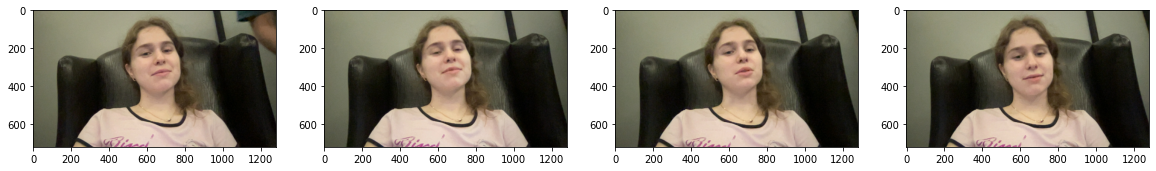

In [37]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

Manually splitting data into train test and val

In [41]:
30 * .7 # 24 will be for training

21.0

In [40]:
30*.15 # 5 and 3 for test and val

4.5

In [44]:
import os

In [45]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

# Applying Augmentations on Images and Labels using Albumentations

In [46]:
import albumentations as alb
import cv2
import json

In [47]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                           alb.HorizontalFlip(p=0.5),
                           alb.RandomBrightnessContrast(p=0.2),
                           alb.RandomGamma(p=0.2),
                           alb.RGBShift(p=0.2),
                           alb.VerticalFlip(p=0.5)],
                          bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

In [48]:
img = cv2.imread(os.path.join('data', 'train', 'images', '0aff622a-cfab-11ec-825e-9230ca590061.jpg'))

In [49]:
with open(os.path.join('data', 'train', 'labels', '0aff622a-cfab-11ec-825e-9230ca590061.json'), 'r') as f:
    label = json.load(f)


In [50]:
label['shapes'][0]['points']

[[478.45205479452056, 25.54794520547945],
 [838.7260273972603, 491.30136986301375]]